In [11]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from keplergl import KeplerGl
import math
%matplotlib inline
from io import BytesIO
from shapely.geometry import Point, Polygon
from fiona.crs import from_epsg

In [32]:

immi=pd.read_csv('../resource/transit/Baidu_Immig_20200101-20200202.csv', encoding='gb2312')
pop=pd.read_csv('../data/province_population.csv')
pop=pop[:31].sort_values('province_cn')


,province_en,pop_18_m,province_cn
8,Shanghai,24240000,上海
24,Yunnan,48300000,云南
4,Inner Mongolia,25340000,内蒙古自治区
0,Beijing,21540000,北京
6,Jilin,27040000,吉林
22,Sichuan,83410000,四川
1,Tianjin,15600000,天津
29,Ningxia,6880000,宁夏回族自治区
11,Anhui,63240000,安徽
14,Shandong,100470000,山东


In [33]:
def cleanprovince(provincename):
    if type(provincename)!=float:
        name=provincename.replace('市','')
        name=name.replace('省','')
        return name
    else:
        return None

In [34]:
location=pd.read_csv('/Users/yuanfan/Documents/COVID-19/data/ChinaCitieswithlocation20200130final_xyz.csv')
location['city_name']=location['city'].apply(lambda x: x.replace('市', '') if type(x)!=float else None)
location['province_clean']=location['province'].apply(cleanprovince)
geocode=location[['lat','lng','city_name']].groupby('city_name').max().reset_index()
geocode

,city_name,lat,lng
0,七台河,45.81597,131.06693
1,万宁,18.79532,110.38975
2,三亚,18.40005,109.75250
3,三明,26.90012,118.19049
4,三沙,16.83272,112.33356
...,...,...,...
364,黔东南苗族侗族自治州,27.17385,109.20776
365,黔南布依族苗族自治州,27.07790,107.88732
366,黔西南布依族苗族自治州,25.83474,106.09962
367,齐齐哈尔,48.48419,126.24871


In [35]:
pckey=location[['province_clean','city_name']]
pckey

,province_clean,city_name
0,上海,上海
1,上海,上海
2,上海,上海
3,上海,上海
4,上海,上海
...,...,...
3241,安徽,六安
3242,广西壮族自治区,贺州
3243,江苏,无锡
3244,新疆维吾尔自治区,昆玉


In [36]:

def cleanmobility(file):
    '''
    This function clean up city name, and convert column names to english
    '''
    df=file.copy()
    df.rename(columns={'迁出城市':'from_city','迁入城市':'to_city','日期':'time','人数':'quantity' }, inplace=True)
    df['time']=df['time'].apply(lambda x: str(x)[:4]+'-'+str(x)[4:6]+'-'+str(x)[6:])
    df['time']=pd.to_datetime(df['time'])
    df['from_city']=df['from_city'].apply(lambda x: x.replace('市', '') if type(x)!=float else None)
    df['to_city']=df['to_city'].apply(lambda x: x.replace('市', '') if type(x)!=float else None)
    

#     df=df[['from_city', 'to_city', 'time', 'quantity', 'from_city',
#        'from_lat', 'from_lon', 'to_city', 'to_lat', 'to_lon','from_province',  'to_province']].drop_duplicates()

    return df

In [37]:
def joingeo(file):
      '''
    This function join the geolocation (lon lat) of different places
    '''
    df=file.copy()
    df=df.merge(geocode, left_on='from_city',right_on='city_name', how='left')
    df=df.merge(geocode, left_on='to_city',right_on='city_name', how='left')
    df.rename(columns={'city_x':'from_city','city_y':'to_city','lng_x':'from_lon','lat_x':'from_lat',
              'lng_y':'to_lon','lat_y':'to_lat'}, inplace=True)
    return df

In [38]:
def mergeprovince(file): 
    '''
    This function merge city to their provinces
    '''
    df=file.copy()
    df=df.merge(pckey, left_on ='to_city',right_on='city_name', how ='left')
    df=df.merge(pckey, left_on ='from_city',right_on='city_name', how ='left')
    df.rename(columns={'province_clean_x':'from_province','province_clean_y':'to_province'}, inplace=True)
    return df

In [39]:
immiDF=cleanmobility(immi)
immiDFF=joingeo(immiDF)
immi_provDFF=mergeprovince(immiDFF)

##### Aggregate data to province level

In [188]:

immi_provDFF2=immi_provDFF.drop_duplicates(subset=['from_city','to_city','time']).fillna({'quantity':0})
provincedf=immi_provDFF2.groupby(['from_province','to_province','time']).agg({'quantity':'sum',
                                                                      'from_lat':'mean',
                                                                      'to_lat':'mean',
                                                                      'from_lon':'mean',
                                                                      'to_lon':'mean'}).reset_index()


/Users/yuanfan/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [189]:
provincedf[provincedf['from_province']==provincedf['to_province']].loc[:,['quantity']]=0

/Users/yuanfan/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [190]:
provincedf

,from_province,to_province,time,quantity,from_lat,to_lat,from_lon,to_lon
0,上海,云南,2020-01-01,198.647640,25.904380,31.622900,102.305075,121.544090
1,上海,云南,2020-01-02,225.857905,25.904380,31.622900,102.305075,121.544090
2,上海,云南,2020-01-03,271.176077,25.904380,31.622900,102.305075,121.544090
3,上海,云南,2020-01-04,335.207711,25.904380,31.622900,102.305075,121.544090
4,上海,云南,2020-01-05,349.673663,25.904380,31.622900,102.305075,121.544090
...,...,...,...,...,...,...,...,...
28694,黑龙江,黑龙江,2020-01-29,30150.694638,47.353247,47.781908,130.207126,129.958123
28695,黑龙江,黑龙江,2020-01-30,30468.506271,47.360116,47.781908,130.227730,129.958123
28696,黑龙江,黑龙江,2020-01-31,24525.869763,47.360116,47.781908,130.227730,129.958123
28697,黑龙江,黑龙江,2020-02-01,19979.129132,47.379247,47.708288,130.181078,130.005006


In [191]:
provincedf.to_csv('/Users/yuanfan/Documents/COVID-19/resource/transit/Baidu_province_0220.csv')

### Create a matrix

In [192]:
provincedf=pd.read_csv('/Users/yuanfan/Documents/COVID-19/resource/transit/Baidu_province_0220.csv')

In [193]:
provincedf.from_province.unique()

array(['上海', '云南', '内蒙古自治区', '北京', '吉林', '四川', '天津', '宁夏回族自治区', '安徽',
       '山东', '山西', '广东', '广西壮族自治区', '新疆维吾尔自治区', '江苏', '江西', '河北', '河南',
       '浙江', '海南', '湖北', '湖南', '甘肃', '福建', '西藏自治区', '贵州', '辽宁', '重庆',
       '陕西', '青海', '黑龙江'], dtype=object)

In [212]:
oneday_mobility=provincedf[provincedf['time']=='2020-01-15']

oneday_mobility=oneday_mobility.drop_duplicates(subset=['from_province','to_province'])

OD_matrix=oneday_mobility.pivot(index='from_province',columns='to_province',values='quantity')
OD_simulate=OD_matrix.interpolate()
remove the interpolation of city to itselves
OD_simulateDF=pd.DataFrame(OD_simulate.stack(), columns=['quantity']).reset_index()
OD_simulateDF=OD_simulateDF[OD_simulateDF['from_province']!=OD_simulateDF['to_province']]
OD_matrixDF=OD_simulateDF.pivot(index='from_province',columns='to_province',values='quantity')
OD_matrixDF.fillna(0,inplace=True)

In [222]:
OD_matrixDF

to_province,上海,云南,内蒙古自治区,北京,吉林,四川,天津,宁夏回族自治区,安徽,山东,...,湖南,甘肃,福建,西藏自治区,贵州,辽宁,重庆,陕西,青海,黑龙江
from_province,,,,,,,,,,,,,,,,,,,,,
上海,0.000000,251.445287,160.243110,2352.093714,289.566155,810.953662,421.846056,98.904110,4969.559822,2296.499818,...,554.908417,203.584234,1205.177713,15.125227,194.057726,612.430114,464.547636,603.936162,33.118049,373.059756
云南,366.680779,0.000000,43.966314,501.461604,45.094514,4989.065108,103.117925,34.580131,197.667022,411.279541,...,424.158606,51.852344,1039.333000,146.015622,5297.817766,102.110609,1170.849654,199.814299,17.830822,61.493807
内蒙古自治区,1477.507846,29085.125350,0.000000,3211.742178,1733.640052,1.077268,876.502361,1720.826046,5.631120,361.277399,...,642.539887,558.962921,907.982152,2.514532,2792.353095,3699.290639,903.023721,2670.997096,6.125155,2109.738215
北京,2588.334912,410.908464,2966.271646,0.000000,998.609116,1443.165530,6360.501089,294.906938,1245.361716,6292.773522,...,860.921168,441.991145,776.631305,41.476471,286.888424,2614.536274,635.197788,1565.402436,128.894911,1459.814076
吉林,269.618220,7.510709,2030.193526,1193.956200,0.000000,73.196525,773.384436,233.074357,49.333406,1195.656811,...,54.063612,5.682150,40.880376,0.816674,2936.080062,5636.958448,12125.641356,7.912372,231.295597,4080.243229
四川,2297.147234,8303.862906,147.493872,1910.329920,98.710650,0.000000,262.481990,171.241776,378.967928,1403.660340,...,802.008184,1298.959092,5201.014374,1419.750666,5585.271700,361.018328,23616.084924,3744.560729,333.696283,188.687815
天津,474.528067,87.298625,500.465174,5444.440272,307.618852,232.104398,0.000000,40.668415,265.309441,2742.999552,...,111.687174,99.576767,164.980800,4.706975,27.622328,827.675431,123.247332,311.929348,15.795518,443.552760
宁夏回族自治区,8708.668506,128.995902,1590.638764,322.368174,7.361345,89.581594,940.560466,0.000000,44433.075852,18.378382,...,301.214878,1641.244129,1338.168827,6.703528,80.159722,735.785321,165.909870,1572.850548,60.640618,0.816091
安徽,16942.808945,170.693179,256.455752,2638.643202,145.621638,267.762672,1279.599703,191.802395,0.000000,4126.575683,...,490.742582,195.623813,2511.356854,36.322085,132.697116,643.895212,208.572408,1107.459896,110.047507,161.903707


## Plug in the model

In [52]:
#Parameter β represents the rate of conversion from “susceptable” to “exposed”
beta= 0.625
#from "exposed" to "infected" with a rate of α: alpha
alpha=1/7 #This could change per serious of the disease

#Parameter γ determines the rate of recovery, 
#while the recovered subjects are removed from the repository of susceptible subjects. y for gamma
gamma= 0.135

R0=beta/gamma

mobility_factor=1 #adjust this to control inflow out flow
max_hospital=10000# assume 10000 people could be in hospital
R0


4.62962962962963

In [61]:
#merge English Name:
def translate(df):
    df=df.merge(pop, left_on='province',right_on='province_cn',how='left')
    return df

In [307]:
def SEIR_Model(seir,OD_matrixDF):
    '''Typical SEIR Model'''
    seir_previous=seir.copy()
    flow_infected_matrix=OD_matrixDF*mobility_factor/Nc * seir_previous[:,2]
    inflow_infected_sum=flow_infected_matrix.sum(axis=1)
    total_infected=seir_previous[:,2]+inflow_infected_sum
    
    new_S=-1*beta*(total_infected)*seir_previous[:,0]/Nc
    new_E=beta*(total_infected)*seir_previous[:,0]/Nc - alpha* seir_previous[:,1]
    new_I = alpha*seir_previous[:,1] - gamma*seir_previous[:,2]
    new_R = gamma*seir_previous[:,2] 
    
    seir[:,0]=seir[:,0]+new_S
    seir[:,1]=seir[:,1]+new_E
    seir[:,2]=seir[:,2]+new_I
    seir[:,3]=seir[:,3]+new_R
    
    return seir

In [ ]:
def C_SEIR_Model(cseir,OD_matrixDF):
    '''Typical SEIR Model +Quanrantine effect by hospital and individual person
    p: exposed and self-quaranteed
    q: infected and quaranteed at hospital
    '''
    cseir_previous=cseir.copy()
    flow_infected_matrix=OD_matrixDF*mobility_factor/Nc * cseir_previous[:,2]
    inflow_infected_sum=flow_infected_matrix.sum(axis=1)
    total_infected=cseir_previous[:,2]+inflow_infected_sum
    
    new_S=-1*beta*(total_infected-p)*cseir_previous[:,0]/Nc
    new_E=beta*(total_infected)*seir_previous[:,0]/Nc - alpha* seir_previous[:,1]
    new_I = alpha*seir_previous[:,1] - gamma*seir_previous[:,2]
    new_R = gamma*seir_previous[:,2] 
    
    seiqr[:,0]=seir[:,0]+new_S
    seiqr[:,1]=seir[:,1]+new_E
    seiqr[:,2]=seir[:,2]+new_I
    seiqr[:,3]=seir[:,3]+new_Q
    seiqr[:,4]=seir[:,4]+new_R
    
    return seir

In [309]:
new_df = pd.DataFrame({'湖北': np.zeros(31)})
def update_mobility(matrix,stop_province='湖北',mobility_fc=0.7):
    '''This function update the mobility matrix after the day Hubei was isolated'''
    newmatrix=matrix.copy()*mobility_fc
    newmatrix[stop_province]=0
    newmatrix.loc[stop_province,:]=0
    
    return newmatrix
newmatrix=update_mobility(OD_matrixDF,stop_province='湖北',mobility_fc=0.7)
newmatrix

to_province,上海,云南,内蒙古自治区,北京,吉林,四川,天津,宁夏回族自治区,安徽,山东,...,湖南,甘肃,福建,西藏自治区,贵州,辽宁,重庆,陕西,青海,黑龙江
from_province,,,,,,,,,,,,,,,,,,,,,
上海,NaN,176.011701,112.170177,1646.465600,202.696308,567.667563,295.292239,69.232877,3478.691876,1607.549872,...,388.435892,142.508964,843.624399,10.587659,135.840408,428.701080,325.183345,422.755313,23.182634,261.141829
云南,256.676545,40431.539565,30.776420,351.023123,31.566160,3492.345576,72.182547,24.206092,138.366915,287.895679,...,296.911024,36.296641,727.533100,102.210935,3708.472436,71.477426,819.594758,139.870009,12.481575,43.045665
内蒙古自治区,1034.255492,20359.587745,23408.528094,2248.219525,1213.548036,0.754087,613.551653,1204.578232,3.941784,252.894179,...,449.777921,391.274045,635.587507,1.760172,1954.647167,2589.503447,632.116605,1869.697967,4.287609,1476.816750
北京,1811.834438,287.635925,2076.390152,1541.994432,699.026381,1010.215871,4452.350762,206.434857,871.753201,4404.941465,...,602.644818,309.393801,543.641913,29.033530,200.821897,1830.175392,444.638452,1095.781705,90.226438,1021.869853
吉林,188.732754,5.257496,1421.135468,835.769340,19701.325829,51.237567,541.369105,163.152050,34.533384,836.959768,...,37.844528,3.977505,28.616263,0.571672,2055.256043,3945.870913,8487.948949,5.538660,161.906918,2856.170260
四川,1608.003064,5812.704034,103.245710,1337.230944,69.097455,113134.610252,183.737393,119.869243,265.277550,982.562238,...,561.405729,909.271364,3640.710062,993.825466,3909.690190,252.712830,16531.259447,2621.192510,233.587398,132.081471
天津,332.169647,61.109037,350.325622,3811.108190,215.333196,162.473079,421.064860,28.467891,185.716609,1920.099686,...,78.181022,69.703737,115.486560,3.294882,19.335630,579.372802,86.273132,218.350543,11.056863,310.486932
宁夏回族自治区,6096.067954,90.297131,1113.447135,225.657722,5.152941,62.707116,658.392326,12829.515691,31103.153097,12.864867,...,210.850415,1148.870890,936.718179,4.692469,56.111806,515.049725,116.136909,1100.995384,42.448432,0.571264
安徽,11859.966261,119.485225,179.519027,1847.050241,101.935147,187.433870,895.719792,134.261676,62020.589584,2888.602978,...,343.519808,136.936669,1757.949798,25.425459,92.887981,450.726648,146.000686,775.221927,77.033255,113.332595


### 2.4 Update mobility count considering quanrantee effects
##### Reduce in-out mobility from hubei to other city =0, other cities places mobility reduce by 30%

In [325]:
# This process didn't consider individual quanrantine, only includes Hubei's city level quanrantine
def run(OD_matrix,beta, gamma, alpha,quarantine_start=62,T=300,quarantine=True):

    #innitiate initial
    Nc=pop['pop_18_m'].values.T#population of different province
    SEIR=np.zeros([len(pop.province_cn.unique()),4])
    SEIR[:,0]=Nc
    first_exposed=np.where(SEIR[:, 0]==59170000,1,0)
    SEIR[:, 0] = SEIR[:, 0] - first_exposed # suscepticles -1
    SEIR[:, 1] = SEIR[:, 1] + first_exposed #
    SEIR[:, 2] = SEIR[:, 2] + first_exposed*alpha# move infections to the I group


    
    output=pd.DataFrame({"day":[],"province":[],"susceptics":[],"exposed":[],"infected":[],"recover":[]})
    provincelist=pop.province_cn.unique()
    OD_matrix_norm=OD_matrix.copy()
    OD_matrix_update=update_mobility(OD_matrix,stop_province='湖北',mobility_fc=0.7)
    
    if not quarantine:
        for i in range(T):
            SEIR=SEIR_Model(SEIR,OD_matrix)
            day=np.full(len(provincelist),i)
            new=pd.DataFrame({"day":day,"province":provincelist,"susceptics": SEIR[:,0],
                          "exposed": SEIR[:,1],"infected": SEIR[:,2],"recover": SEIR[:,3]})
            output=pd.concat([output,new], sort=False)
    else:
        for i in range(T):
            if i<quarantine_start:
                SEIR=SEIR_Model(SEIR,OD_matrix_norm)

            else:
                SEIR=SEIR_Model(SEIR,OD_matrix_update)
            day=np.full(len(provincelist),i)
            new=pd.DataFrame({"day":day,"province":provincelist,"susceptics": SEIR[:,0],
                          "exposed": SEIR[:,1],"infected": SEIR[:,2],"recover": SEIR[:,3]})
            output=pd.concat([output,new], sort=False)
            
                
    output=translate(output)
    output.day=output.day.astype(int)
    return output

output=run(OD_matrixDF, beta, gamma, alpha,quarantine_start=62,T=300,quarantine=False)

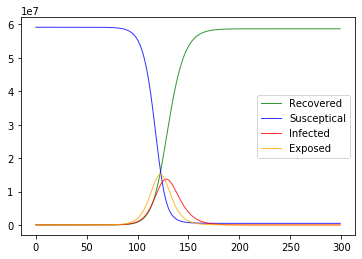

In [326]:
sh=output[output['province_en']=='Hubei']
plt.plot(sh['day'],sh['recover'], marker='', color='green', linewidth=1, alpha=0.8, label='Recovered')
plt.plot(sh['day'],sh['susceptics'], marker='', color='blue', linewidth=1, alpha=0.8, label='Susceptical')
plt.plot(sh['day'],sh['infected'], marker='', color='red', linewidth=1, alpha=0.8, label='Infected')
plt.plot(sh['day'],sh['exposed'], marker='', color='orange', linewidth=1, alpha=0.8, label='Exposed')
plt.legend()

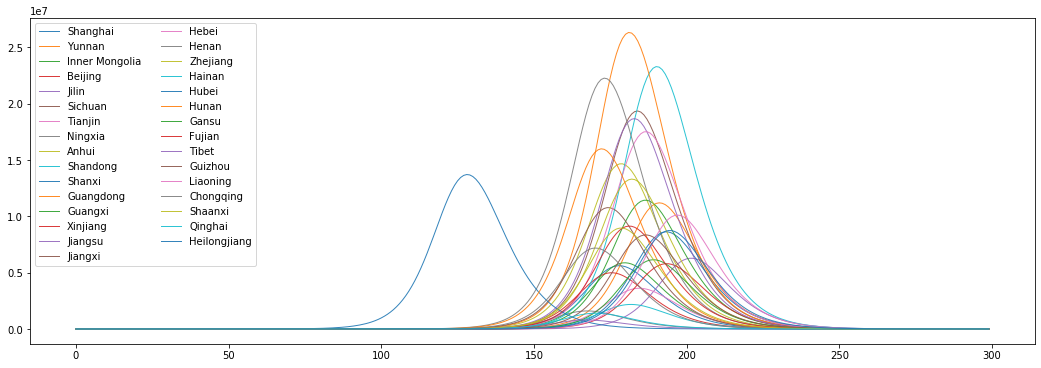

In [327]:
def plotall_province(output,periods):
    output2=output[output['day']<periods]
    fig=plt.figure(figsize=(18,6))
    for i, province in enumerate(output2['province_en'].unique()):
        df=output2[output2['province_en']==province]
        plt.plot(df['day'], df['infected'], marker='', linewidth=1, alpha=0.9, label=province)
    plt.legend(loc=2, ncol=2)
plotall_province(output,300)

In [66]:
def normal(SEIR):
    '''
    this function normalize the data by each province population'''
    SEIR_norm=SEIR.copy()
    SEIR_norm[:,0]=SEIR[:, 0]/Nc
    SEIR_norm[:,1]=SEIR[:, 1]/Nc
    SEIR_norm[:,2]=SEIR[:, 2]/Nc
    SEIR_norm[:,3]=SEIR[:, 3]/Nc
    return SEIR_norm

In [345]:
T=300
#innitiate initial
Nc=pop['pop_18_m'].values.T#population of different province
SEIR=np.zeros([len(pop.province_cn.unique()),4])
SEIR[:,0]=Nc
first_exposed=np.where(SEIR[:, 0]==59170000,1,0)
SEIR[:, 0] = SEIR[:, 0] - first_exposed # suscepticles -1
SEIR[:, 1] = SEIR[:, 1] + first_exposed #
SEIR[:, 2] = SEIR[:, 2] + first_exposed*alpha# move infections to the I group


OD_matrixDF=OD_simulate.copy()
output_q=pd.DataFrame({"day":[],"province":[],"susceptics":[],"exposed":[],"infected":[],"recover":[]})
#SEIR_Model(SEIR,OD_matrixDF)
provincelist=pop.province_cn.unique()
for i in range(30):
    SEIR=SEIR_Model(SEIR,OD_matrixDF)
    day=np.full(len(provincelist),i)
    new=pd.DataFrame({"day":day,"province":provincelist,"susceptics": SEIR[:,0],
                  "exposed": SEIR[:,1],"infected": SEIR[:,2],"recover": SEIR[:,3]})
    output_q=pd.concat([output_q,new], sort=False)

# output_norm=translate(output_norm)
# output_norm.tail()

In [346]:
for i in range(30,300):
    SEIR=SEIR_Model(SEIR,newmatrix)
    day=np.full(len(provincelist),i)
    new=pd.DataFrame({"day":day,"province":provincelist,"susceptics": SEIR[:,0],
                  "exposed": SEIR[:,1],"infected": SEIR[:,2],"recover": SEIR[:,3]})
    output_q=pd.concat([output_q,new], sort=False)
output_q=translate(output_q)
output_q

,day,province,susceptics,exposed,infected,recover,province_en,pop_18_m,province_cn
0,0.0,上海,2.424000e+07,1.456578e-06,0.000000,0.000000e+00,Shanghai,24240000,上海
1,0.0,云南,4.830000e+07,3.974288e-07,0.000000,0.000000e+00,Yunnan,48300000,云南
2,0.0,内蒙古自治区,2.534000e+07,1.141022e-06,0.000000,0.000000e+00,Inner Mongolia,25340000,内蒙古自治区
3,0.0,北京,2.154000e+07,1.884615e-06,0.000000,0.000000e+00,Beijing,21540000,北京
4,0.0,吉林,2.704000e+07,3.285595e-09,0.000000,0.000000e+00,Jilin,27040000,吉林
...,...,...,...,...,...,...,...,...,...
9295,299.0,辽宁,3.441901e+05,1.514173e+02,932.982233,4.324473e+07,Liaoning,43590000,辽宁
9296,299.0,重庆,2.448901e+05,4.494422e+00,27.843365,3.077508e+07,Chongqing,31020000,重庆
9297,299.0,陕西,3.040474e+05,1.506049e+01,93.584162,3.833584e+07,Shaanxi,38640000,陕西
9298,299.0,青海,4.741137e+04,8.995274e-01,5.548793,5.982582e+06,Qinghai,6030000,青海


In [338]:
def plotall_province(output,periods):
    output2=output[output['day']<periods]
    fig=plt.figure(figsize=(18,6))
    for i, province in enumerate(output2['province_en'].unique()):
        df=output2[output2['province_en']==province]
        plt.plot(df['day'], df['infected'], marker='', linewidth=1, alpha=0.9, label=province)
    plt.legend(loc=2, ncol=2)

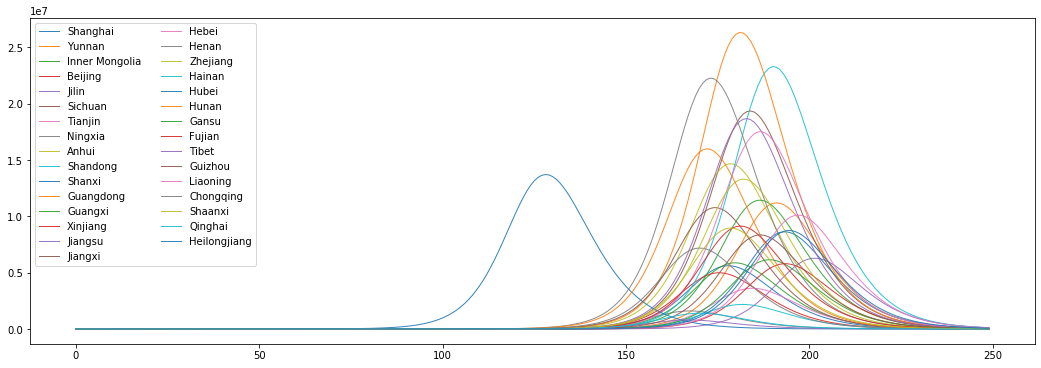

In [369]:
#no quanrantine at all
plotall_province(output,250)

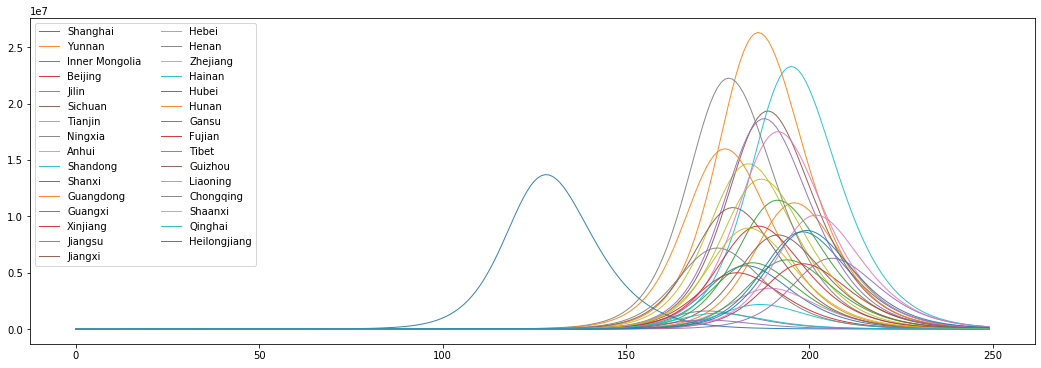

In [374]:
#quanrantine at 60th day
plotall_province(output_q,250)

In [373]:
output_q=run(OD_matrixDF, beta, gamma, alpha,quarantine_start=60,T=300,quarantine=True)

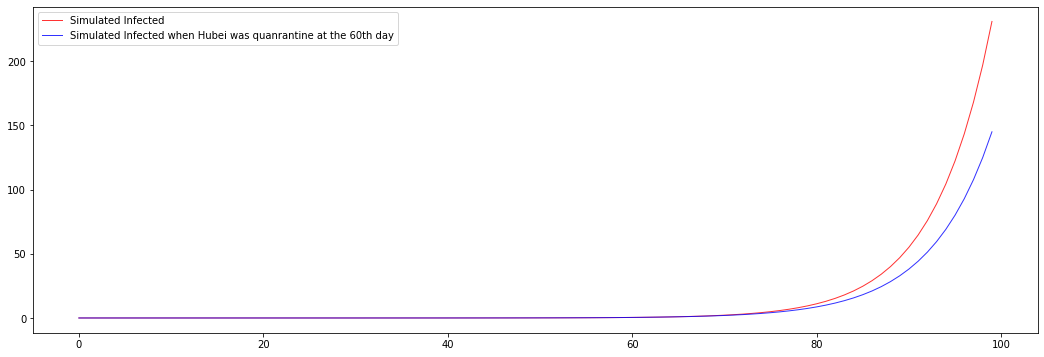

In [357]:
def plotsingleprovince(province_name,day):
    bj=output[output['province_en']==province_name][:day]
    bj_q=output_q[output_q['province_en']==province_name][:day]
    fig=plt.figure(figsize=(18,6))
    plt.plot(bj['day'],bj['infected'],marker='',color='red',linewidth=1, 
             alpha=0.8,label='Simulated Infected')
    plt.plot(bj_q['day'],bj_q['infected'],marker='',color='blue',linewidth=1, 
             alpha=0.8,label='Simulated Infected when Hubei was quanrantine at the 60th day')
    plt.legend()
    
plotsingleprovince('Beijing',100)

In [68]:
geo=provincedf.drop_duplicates(subset=['from_lon'])
geo=geo[['to_province','from_lat','from_lon']].reset_index()
geo

,index,to_province,from_lat,from_lon
0,0,云南,25.904380,102.305075
1,23,云南,26.093523,102.615641
2,33,内蒙古自治区,43.389009,115.393649
3,43,内蒙古自治区,43.591403,116.142694
4,64,内蒙古自治区,43.799806,116.338324
...,...,...,...,...
18976,28684,黑龙江,47.347728,130.214965
18977,28686,黑龙江,47.347797,130.222238
18978,28687,黑龙江,47.349392,130.233558
18979,28691,黑龙江,47.357353,130.158682


In [73]:
def mergegeo(output):
    temp=geo.merge(output,left_on='to_province',right_on='province', how='left')
    temp2=temp.drop_duplicates(subset=['day','to_province','exposed','infected','recover']).reset_index()
    temp2['susceptics']=temp2['susceptics'].apply(lambda x: round(x,3))
    temp2['recover']=temp2['recover'].apply(lambda x: round(x,3))
    temp2['exposed']=temp2['exposed'].apply(lambda x: round(x,3))
    temp2['infected']=temp2['infected'].apply(lambda x: round(x,3))
    output_clean=temp2[['day', 'province', 'susceptics', 'exposed', 'infected', 'recover','from_lat', 'from_lon','province_en']]
    return output_clean
    

In [74]:
out1=mergegeo(output)
out1

,day,province,susceptics,exposed,infected,recover,from_lat,from_lon,province_en
0,0.0,云南,4.830000e+07,0.000,0.000,0.000000e+00,25.90438,102.305075,Yunnan
1,1.0,云南,4.830000e+07,0.000,0.000,0.000000e+00,25.90438,102.305075,Yunnan
2,2.0,云南,4.830000e+07,0.000,0.000,0.000000e+00,25.90438,102.305075,Yunnan
3,3.0,云南,4.830000e+07,0.000,0.000,0.000000e+00,25.90438,102.305075,Yunnan
4,4.0,云南,4.830000e+07,0.000,0.000,0.000000e+00,25.90438,102.305075,Yunnan
...,...,...,...,...,...,...,...,...,...
9295,295.0,上海,1.902623e+05,4.506,28.042,2.404971e+07,31.62290,121.544090,Shanghai
9296,296.0,上海,1.902622e+05,4.001,24.900,2.404971e+07,31.62290,121.544090,Shanghai
9297,297.0,上海,1.902621e+05,3.552,22.110,2.404971e+07,31.62290,121.544090,Shanghai
9298,298.0,上海,1.902620e+05,3.154,19.633,2.404972e+07,31.62290,121.544090,Shanghai


In [533]:
out_norm=mergegeo(output_norm)

In [75]:
out1.to_csv('/Users/yuanfan/Documents/COVID-19/output/modeloutput0220_300day.csv')
#out_norm.to_csv('/Users/yuanfan/Documents/COVID-19/output/modeloutput0217_norm300day.csv')

### 2.5 Compare the real infection data

In [271]:
jhk_df=pd.read_csv('./data/JHU_CSSE/timeseries_combined.csv')
jhk_df.columns


Index(['Unnamed: 0', 'level_0', 'time', 'confirmed', 'Province/State',
       'Country/Region', 'Lat', 'Long', 'ID', 'recover', 'death'],
      dtype='object')

In [274]:
jhk_china=jhk_df[jhk_df['Country/Region']=='Mainland China']

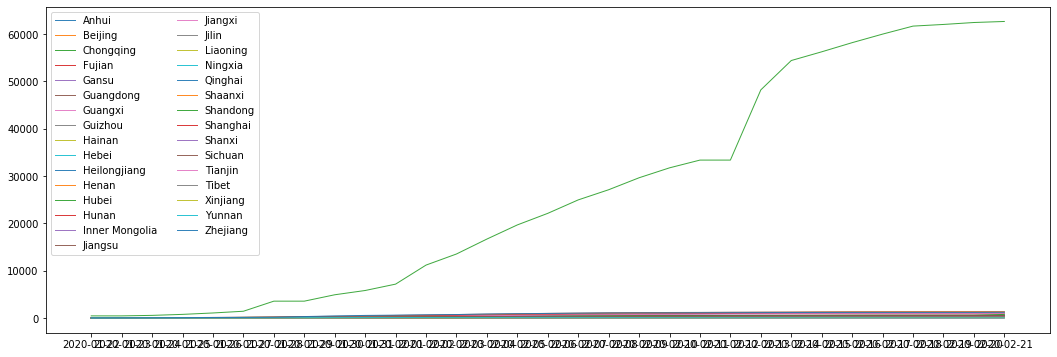

In [275]:
def plotall_province_reality(output):
    output2=output.copy()
    fig=plt.figure(figsize=(18,6))
    for i, province in enumerate(output2['Province/State'].unique()):
        df=output2[output2['Province/State']==province]
        plt.plot(df['time'], df['confirmed'], marker='', linewidth=1, alpha=0.9, label=province)
    plt.legend(loc=2, ncol=2)
plotall_province_reality(jhk_china)

In [287]:
bj_reality=jhk_china[jhk_china['Province/State']=='Beijing']
bj_simulate=output_quanrantine[output_quanrantine['province_en']=='Beijing']
bj_simulate=bj_simulate.merge(timedf,on='day', how='left')
bj_simulate

,day,province,susceptics,exposed,infected,recover,province_en,pop_18_m,province_cn,time
0,0,北京,2.154000e+07,0.000002,0.000000e+00,0.000000e+00,Beijing,21540000,北京,2019-11-22
1,1,北京,2.154000e+07,0.000005,2.692308e-07,0.000000e+00,Beijing,21540000,北京,2019-11-23
2,2,北京,2.154000e+07,0.000009,9.657692e-07,3.634615e-08,Beijing,21540000,北京,2019-11-24
3,3,北京,2.154000e+07,0.000015,2.176784e-06,1.667250e-07,Beijing,21540000,北京,2019-11-25
4,4,北京,2.154000e+07,0.000021,3.978366e-06,4.605908e-07,Beijing,21540000,北京,2019-11-26
...,...,...,...,...,...,...,...,...,...,...
295,295,北京,1.679712e+05,2.995818,1.860591e+01,2.137201e+07,Beijing,21540000,北京,2020-09-12
296,296,北京,1.679711e+05,2.659967,1.652209e+01,2.137201e+07,Beijing,21540000,北京,2020-09-13
297,297,北京,1.679710e+05,2.361777,1.467160e+01,2.137201e+07,Beijing,21540000,北京,2020-09-14
298,298,北京,1.679709e+05,2.097023,1.302833e+01,2.137201e+07,Beijing,21540000,北京,2020-09-15


In [105]:
firstday=hb[hb['infected']>400].reset_index().at[0,'day']
jhk_df.time=pd.to_datetime(jhk_df['time'])
firstday_report=jhk_df.at[0,'time']
firstday_report

Timestamp('2020-01-22 00:00:00')

In [152]:
#create actual date time for the output
newsfirstday=pd.to_datetime('2019-12-01')
#datelist_before=pd.date_range(end=firstday_report-pd.DateOffset(days=9), periods=47)

daterange=pd.date_range(newsfirstday-pd.DateOffset(days=9),periods=300)
daterange
timedf=pd.DataFrame({'time':daterange,'day':np.arange(0,300)})
timedf

,time,day
0,2019-11-22,0
1,2019-11-23,1
2,2019-11-24,2
3,2019-11-25,3
4,2019-11-26,4
...,...,...
295,2020-09-12,295
296,2020-09-13,296
297,2020-09-14,297
298,2020-09-15,298


In [153]:
output=output.merge(timedf,on='day', how='left')
output

,day,province,susceptics,exposed,infected,recover,province_en,pop_18_m,province_cn,time_x,time_y,time
0,0,上海,2.424000e+07,1.456578e-06,0.000000,0.000000e+00,Shanghai,24240000,上海,2019-12-06,2019-11-28,2019-11-22
1,0,云南,4.830000e+07,3.974288e-07,0.000000,0.000000e+00,Yunnan,48300000,云南,2019-12-06,2019-11-28,2019-11-22
2,0,内蒙古自治区,2.534000e+07,1.141022e-06,0.000000,0.000000e+00,Inner Mongolia,25340000,内蒙古自治区,2019-12-06,2019-11-28,2019-11-22
3,0,北京,2.154000e+07,1.884615e-06,0.000000,0.000000e+00,Beijing,21540000,北京,2019-12-06,2019-11-28,2019-11-22
4,0,吉林,2.704000e+07,3.285595e-09,0.000000,0.000000e+00,Jilin,27040000,吉林,2019-12-06,2019-11-28,2019-11-22
...,...,...,...,...,...,...,...,...,...,...,...,...
9295,299,辽宁,3.454535e+05,4.991136e+01,308.557733,4.324419e+07,Liaoning,43590000,辽宁,2020-09-30,2020-09-22,2020-09-16
9296,299,重庆,2.438225e+05,1.434016e+00,8.895606,3.077617e+07,Chongqing,31020000,重庆,2020-09-30,2020-09-22,2020-09-16
9297,299,陕西,3.059359e+05,4.989934e+00,30.958082,3.833403e+07,Shaanxi,38640000,陕西,2020-09-30,2020-09-22,2020-09-16
9298,299,青海,4.738867e+04,2.953274e-01,1.814938,5.982609e+06,Qinghai,6030000,青海,2020-09-30,2020-09-22,2020-09-16


In [233]:
# hb=output[output['province_en']=='Hubei']
# hb_150=hb[hb['day']<=85].reset_index()
hb_150[hb_150['time']=='2020-01-23']


,index,day,province,susceptics,exposed,infected,recover,province_en,pop_18_m,province_cn,time_x,time_y,time
62,1942,62,湖北,5.915607e+07,7358.423386,3564.778924,3009.340992,Hubei,59170000,湖北,2020-02-06,2020-01-29,2020-01-23


/Users/yuanfan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


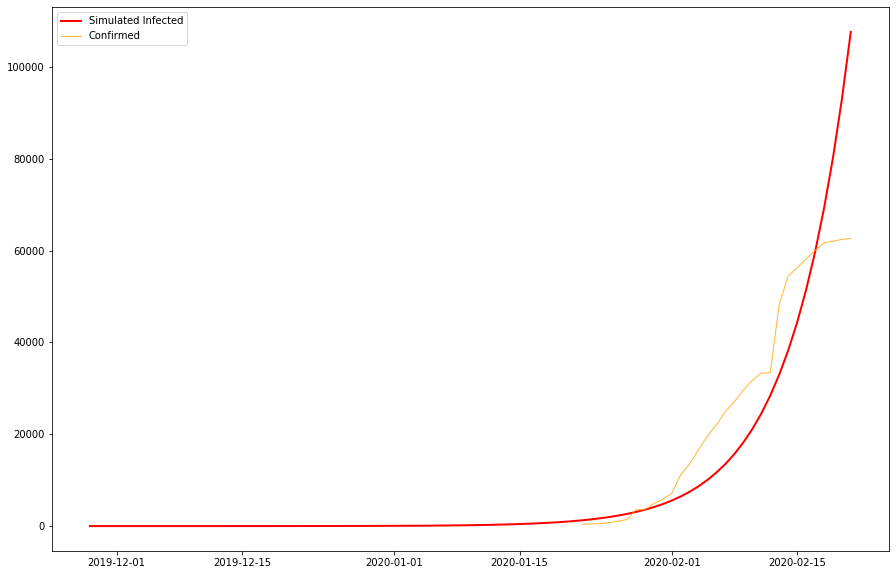

In [159]:
hbcurrent=jhk_df[jhk_df['Province/State']=='Hubei']
fig=plt.figure(figsize=(15,10))
plt.plot(hb_150['time_y'],hb_150['infected'],marker='', color='red', linewidth=2, label='Simulated Infected')
plt.plot(hbcurrent['time'],hbcurrent['confirmed'], marker='', color='orange', linewidth=1, alpha=0.8, label='Confirmed')
plt.legend()
fig.show()

### 3. Join data to polygons only use normalized Infected number

In [395]:
import geopandas as gpd
provinceshp=gpd.read_file('/Users/yuanfan/Documents/COVID-19/data/shp/CHGIS_V4_1997_PROV_PGN-shapefile/CHGIS_V4_1997_PROV_PGN.shp')
provinceshp.head()

,GBCODE90,NAME_PY,NAME_HZ,SDE2_CHGIS,SDE2_CHG_1,SHAPE_AREA,SHAPE_LEN,geometry
0,340000,Anhui,å®å¾½,0.0,0.0,1.413467e+11,2.924949e+06,"POLYGON ((119.6172505479281 31.1433422691972, ..."
1,110000,Beijing,åäº¬,0.0,0.0,1.671717e+10,7.741163e+05,"POLYGON ((117.3792055552632 40.23052350398719,..."
2,350000,Fujian,ç¦å»º,0.0,0.0,1.230045e+11,4.389994e+06,(POLYGON ((120.4301423399292 27.17881136758201...
3,620000,Gansu,çè,0.0,0.0,4.128726e+11,7.403188e+06,"POLYGON ((97.1278902595399 42.78588812153343, ..."
4,440000,Guangdong,å»£æ±,0.0,0.0,1.774517e+11,5.754889e+06,(POLYGON ((113.9677896829623 25.47001025281196...


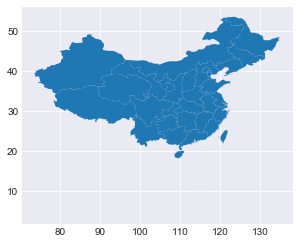

In [486]:
provinceGDF=provinceshp[['NAME_PY','geometry']].merge(pop, right_on='province_en',left_on='NAME_PY', how='outer').reset_index()
provinceGDF.plot()

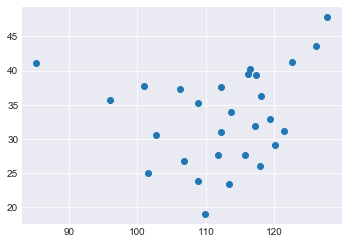

In [442]:
province_center=gpd.GeoDataFrame({'province_en':provinceshp.NAME_PY,'geometry':new})
province_center.crs=from_epsg(4326)
province_center.plot()

In [428]:
newprov=['Hong Kong','Hubei','Hunan','Jiangsu','Jiangxi','Jilin']
newprove=['香港','湖北','湖南','江苏','江西','吉林']

In [432]:
s=out[out['province'].isin(newprove)].drop_duplicates(subset=['province'])

In [453]:
province_center.at[32,'province_en']='Chongqing'

In [456]:
province_center=province_center.drop_duplicates(subset=['province_en'])

In [444]:
province_center['lat']=province_center.dropna().geometry.y
province_center['lon']=province_center.dropna().geometry.x

province_center.at[12,'lat']=31.060170
province_center.at[13,'lat']=28.161872
province_center.at[14,'lat']=33.117228
province_center.at[15,'lat']=28.422474
province_center.at[16,'lat']=43.973113
province_center.at[11,'lat']=22.3193

province_center.at[12,'lon']=113.486531
province_center.at[13,'lon']=112.562164
province_center.at[14,'lon']=119.850530
province_center.at[15,'lon']=116.281677
province_center.at[16,'lon']=126.181140
province_center.at[11,'lon']=114.1694
#province_center2=province_center.drop('geometry')
province_center['geometry']=gpd.points_from_xy(province_center.lon,province_center.lat)

In [483]:
province_center.at[23,'lat']=35.8940
province_center.at[23,'lon']=117.9249


province_center.at[22,'lat']=35.3940
province_center.at[22,'lon']=109.1880

,province_en,geometry,lat,lon
0,Anhui,POINT (117.2222504563598 31.82496727288686),31.824967,117.222250
1,Beijing,POINT (116.409473555488 40.18845861634793),40.188459,116.409474
2,Fujian,POINT (117.9874857777435 26.07627218185339),26.076272,117.987486
3,Gansu,POINT (100.9314339858339 37.81214271464451),37.812143,100.931434
4,Guangdong,POINT (113.4259894432272 23.34799927987221),23.347999,113.425989
5,Guangxi,POINT (108.7869045387989 23.83349038800328),23.833490,108.786905
6,Guizhou,POINT (106.8790892696292 26.81518539681465),26.815185,106.879089
7,Hainan,POINT (109.8724726082538 18.96483663851187),18.964837,109.872473
8,Hebei,POINT (116.1364199677706 39.5505472137912),39.550547,116.136420
9,Heilongjiang,POINT (127.7719678755442 47.86426051494085),47.864261,127.771968


In [411]:
out['day']=out['day'].apply(lambda x: str(int(x)))

In [478]:

simulation=out[['day', 'province', 'infected']].pivot(index='province', columns='day',values='infected').reset_index()
provinceGDF=province_centergdf.merge(simulation, left_on='province_cn', right_on='province', how='outer')


In [462]:
# province_centergdf=pop.merge(province_center,on='province_en',how='outer')
# province_centergdf.at[2,'lat']=43.3782
# province_centergdf.at[2,'lon']=115.0595
# province_centergdf.at[24,'lat']=30.1534
# province_centergdf.at[24,'lat']=88.7879
province_centergdf=gpd.GeoDataFrame(province_centergdf)
province_centergdf.geometry=gpd.points_from_xy(province_centergdf.lon,province_centergdf.lat)
province_centergdf.crs=from_epsg(4326)

In [481]:
provinceGDF

,province_en,pop_18_m,province_cn,geometry,lat,lon,province,0,1,10,...,90,91,92,93,94,95,96,97,98,99
0,Shanghai,24240000.0,上海,POINT (96.00522177851735 35.74641273934164),35.746413,96.005222,上海,0.0,0.0,0.0,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,Yunnan,48300000.0,云南,POINT (85.212625911648 41.12481713689076),41.124817,85.212626,云南,0.0,0.0,0.0,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,Inner Mongolia,25340000.0,内蒙古,POINT (115.0595 43.3782),43.378200,115.059500,内蒙古,0.0,0.0,0.0,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,Beijing,21540000.0,北京,POINT (116.409473555488 40.18845861634793),40.188459,116.409474,北京,0.0,0.0,0.0,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,Jilin,27040000.0,吉林,POINT (126.18114 43.973113),43.973113,126.181140,吉林,0.0,0.0,0.0,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
5,Sichuan,83410000.0,四川,POINT (102.7117096160632 30.61291626218982),30.612916,102.711710,四川,0.0,0.0,0.0,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
6,Tianjin,15600000.0,天津,POINT (121.435132713711 31.19627163939813),31.196272,121.435133,天津,0.0,0.0,0.0,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
7,Ningxia,6880000.0,宁夏,POINT (115.7215742767242 27.61478389566441),27.614784,115.721574,宁夏,0.0,0.0,0.0,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
8,Anhui,63240000.0,安徽,POINT (117.2222504563598 31.82496727288686),31.824967,117.222250,安徽,0.0,0.0,0.0,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
9,Shandong,100470000.0,山东,POINT (106.1692287280767 37.26986193118244),37.269862,106.169229,山东,0.0,0.0,0.0,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [482]:
provinceGDF.to_file('/Users/yuanfan/Documents/COVID-19/output/shp/province_infected_pl.shp')
